In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import progressbar
from random import randint

In [2]:
eps = np.finfo(np.float32).eps

# Data
The directory DATA contains three directories :
- SIG contains 12 repetitions of numbers from 0 to 9 by speaker1 ($Fe = 8000kHz$). SIG_Rep_5_Number_3.wav is the recording corresponding to the fifth repetition of the number "3" . The first four repetitions of each number are represented on Figure 1.
- SIG2, contains 6 repetitions of numbers from 0 to 9 by speaker2
- SIG_MIXED contains 6 repetitions of the number by speaker1 (SIG_MIXED_Rep_1:6) and then by speaker2 ( SIG_MIXED_Rep_7:12).

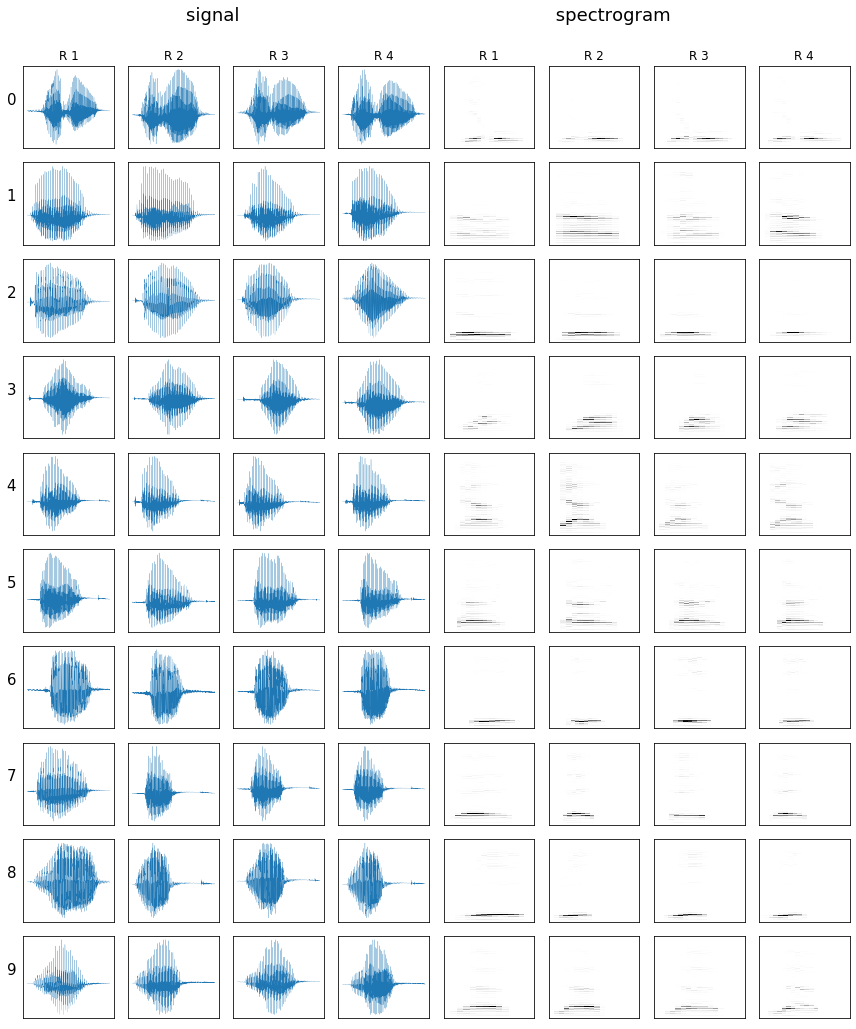

In [3]:
# Load data and plot some of them
signals = {}
plt.figure(figsize=(12,15))
for number in np.arange(0,10):
    for R in np.arange(1,13):
        key = 'R_'+str(R)+'_N_'+str(number)
        sample_rate, signals[key] = wavfile.read('Data/SIG/SIG_Rep_'+str(R)+'_Number_'+str(number)+'.wav')
        
        if R < 5:
            s = 4*number+R
            plt.subplot(10,8,s+4*number)
            plt.plot(signals[key],linewidth=0.2)
            plt.xticks(()),plt.yticks(())
            if number == 0: plt.title('R '+str(R))
            if R ==1 : plt.ylabel(str(number)+'   ',rotation=0,fontsize=15)
        
            f, t, Sxx = spectrogram(signals[key],sample_rate)
            plt.subplot(10,8,s+4*(number+1))
            plt.imshow(Sxx,cmap="gray_r",origin='lower',aspect='auto')
            plt.xticks(()),plt.yticks(())        
            if number == 0: plt.title('R '+str(R))
plt.suptitle('signal'+55*' '+'spectrogram',fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Speech Feature Extraction
Calculate the cepstral parameterization associated with each pronunciation. With regard to the parameters of the analysis, the following choices will be preferred :

*Parameters* :
- **Window size** 256 samples (32 ms)
- **Window shift** 128 samples
- **Weigthing window** Hanning
- **Cepstral order** p = 10   

*Output* :  
**cepstral vectors $\in \mathbb{R}^{N \times p}$ :**
$
\left[\begin{array}{ccc} 
    \ldots  & X_1     & \ldots \\
            & \vdots  &        \\
    \ldots  & X_{n_X} & \ldots \\
\end{array}\right]
$

In [4]:
def cepstral_representation(signal, window_size=256, window_shift=128, order=10):
    
    # initialize
    N = len(signal)
    n_window = int(N/(window_size-window_shift))
    cepstral_vectors = np.zeros((n_window,order))
    # loop on windows
    for n in range(n_window-1):
        # crop window
        L = n*(window_size-window_shift)
        idx_window    = np.arange(L,L + window_size)
        signal_window = signal[idx_window]
        # get spectrum
        spectre = np.fft.fft(signal_window)
        # apply filter
        spectre_filter = np.hanning(window_size) * spectre
        # take the log
        log_spectre = np.log(abs(spectre_filter + eps))
        # iFFT
        cepstrum = np.real(np.fft.ifft(log_spectre))
        # keep first point
        cepstral_vectors[n,:] = cepstrum[:order]
        
    return cepstral_vectors

Test the function

In [5]:
cepstral_vectors = cepstral_representation(signals['R_1_N_0'])

# Time alignment by dynamic programming

In [6]:
def map_indices(idx_array,m,n,gamma):
    '''
    Transform values scalar 0, 1, 2 into (i,j) indices of matrix for getting indices of optimal path
    
    inputs :
      - idx_array < nX,nY > : array with values 0,1,2 meaning which element give the minimum distance
      - m < 1 >             : line index of the element we want to find the minimum distance element
      - n < 1 >             : column index of the element we want to find the minimum distance element
      - gamma < 1 >         : weigth on diagonal element
    outputs :
      - i < 1 > : line index of the minimum distance element
      - j < 1 > : column index of the minimum distance element
      - w < 1 > : weight used
    '''
    idx = idx_array[m,n]
    if idx == 0:
        i, j = m-1, n-1
        w = 1
    if idx == 1:
        i, j = m-1, n
        w = 1
    if idx == 2:
        i, j = m, n-1
        w = gamma
        
    return i, j, w

In [7]:
def time_alignment(X, Y, gamma, normalize=True):
    '''
    Dynamic Time Warping algorithm : perform time alignment by dynamic programming between two sequences of vectors.
    
    inputs : 
      - X < nX,p >      : 1st array 
      - Y < nY,p >      : 2nd array 
      - gamma < 1 >     : parameters to put weight on diagonal elements
      - normalize < 1 > : boolean to normalize the optimal distance by the weight
    outputs :
      - M < o,2 >   : optimal path
      - D_opt < 1 > : sum of locales distances for optimal path
      - C < nX,nY > : cumulatives distances matrix
      - C_opt < 1 > : sum of cumulatives distances for optimal path
    '''
    
    # initialize
    n_X = X.shape[0]
    n_Y = Y.shape[0]
    D   = np.zeros((n_X,n_Y))
    C   = np.zeros((n_X,n_Y))
    idx = np.zeros((n_X,n_Y))
    
    # similarity matrix
    for i in np.arange(0,n_X):
        for j in np.arange(0,n_Y):
            D[i,j] = np.linalg.norm(X[i,:]-Y[j,:])**2
    
    # cumulative distance matrix
    C[0,:] = np.cumsum(D[0,:])
    C[:,0] = np.cumsum(D[:,0])
    for i in np.arange(1,min(n_X,n_Y)):
        for n in np.arange(i,n_X):
            neighbors = [C[n-1,i-1] + gamma*D[n,i], C[n-1,i] + D[n,i], C[n,i-1] + D[n,i]]
            idx[n,i]  = np.argmin(neighbors)
            C[n,i]    = np.min(neighbors)
        for m in np.arange(i,n_Y):
            neighbors = [C[i-1,m-1] + gamma*D[i,m], C[i-1,m] + D[i,m], C[i,m-1] + D[i,m]]
            idx[i,m]  = np.argmin(neighbors)
            C[i,m]    = np.min(neighbors)

    # backtracking        
    M = [] 
    M.append([n_X-1,n_Y-1])
    D_opt = D[n_X-1,n_Y-1]
    C_opt = C[n_X-1,n_Y-1]
    i, j  = n_X-1, n_Y-1
    weights = 0
    while i!=0 and j!=0:
        i,j, w = map_indices(idx,i,j,gamma)
        weights += w
        M.append([i,j])
        D_opt = D_opt + D[i,j]
        C_opt = C_opt + C[i,j]
    
    M = np.array(M[::-1]) # reverse order
    
    if normalize:
        D_opt = D_opt/weights # normalize by the sum of weights used in optimal path
    
    return M, D_opt, C, C_opt

# Application to speech data

In [8]:
sample_rate, signal_ref = wavfile.read('Data/SIG/SIG_Rep_1_Number_0.wav')

Display cumulative distances matrix for different values of $\gamma$ between data *'SIG_Rep_1_Number_0.wav'* and *'SIG_Rep_2_Number_0.wav'*

In [9]:
def display_path(C, M, D_opt, title, colorbar=True):
    'Function used to display cumulative distance matrix with optimal path'
    
    path = np.zeros(C.shape)
    for m in M: path[m[0],m[1]] = 1
    path[path==0] = None
    plt.imshow(C,cmap="gray_r",origin='upper',aspect='auto')
    if colorbar == True: plt.colorbar()
    plt.imshow(path,cmap=plt.cm.hsv,origin='upper',aspect='auto')
    plt.xticks(()), plt.yticks(())
    plt.title(title,color="red",fontsize=15)
    plt.text(0.7, -0.05, "$d=%.2f$" % D_opt, ha='right', va='top', fontsize=12, transform=plt.gca().transAxes)
    

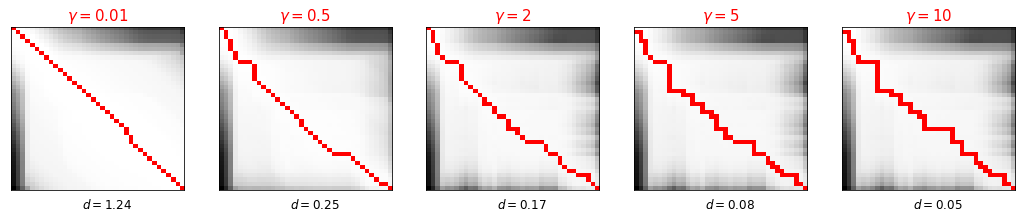

In [10]:
cepstral_vectors_ref = cepstral_representation(signal_ref)
cepstral_vectors     = cepstral_representation(signals['R_2_N_0'])

plt.figure(figsize=(18,3))
gammas = [0.01,0.5,2,5,10]
for i,gamma in enumerate(gammas):
    M, D_opt, C, C_opt = time_alignment(cepstral_vectors_ref, cepstral_vectors, gamma = gamma)
    plt.subplot(1,len(gammas),i+1)
    display_path(C,M,D_opt,"$\gamma="+str(gamma)+str("$"),colorbar=False)
plt.show()

Plot the evolution of the optimal distance for different value of gamma and between R1 and others repetition of the number 0

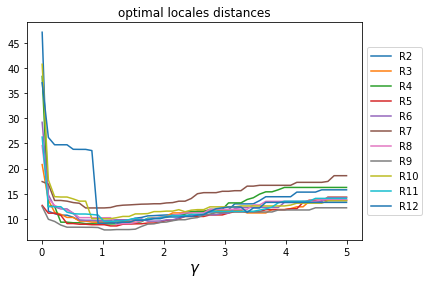

In [11]:
gammas = np.linspace(0.01,5,50)
for r in np.arange(2,13):
    cepstral_vectors = cepstral_representation(signals['R_'+str(r)+'_N_0'])
    dist_loc = np.zeros((len(gammas),))
    for i,gamma in enumerate(gammas):
        M, D_opt, C, C_opt = time_alignment(cepstral_vectors_ref, cepstral_vectors, gamma, normalize = False)
        dist_loc[i] = D_opt
    plt.plot(gammas,dist_loc,label='R'+str(r))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("$\gamma$", fontsize=15)
plt.title("optimal locales distances")
plt.show()

<font color="blue">
Here, by testing different values of $\gamma$ that minimales distances (not normalized) are obtained for $1<\gamma<2$.
</font>

Align the reference sequence with all data (of SIG).

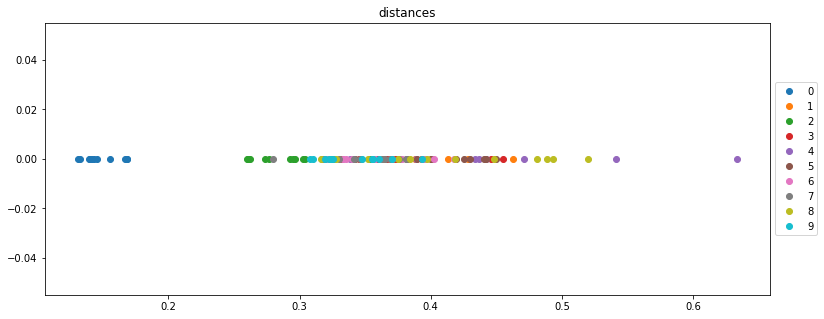

In [12]:
signal_ref = signals["R_1_N_0"]
cepstral_vectors_ref = cepstral_representation(signal_ref)

n = 10
r = 13
plt.figure(figsize=(13,5))
for number in np.arange(0,n):
    distances = []
    for R in np.arange(1,r):
        key = 'R_'+str(R)+'_N_'+str(number)
        if key != "R_1_N_0":
            cepstral_vectors = cepstral_representation(signals[key])
            M, D_opt, C, C_opt = time_alignment(cepstral_vectors_ref, cepstral_vectors, gamma = 2)
            distances.append(D_opt)
    plt.plot(distances, np.zeros_like(distances),'o',label=number)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('distances')
plt.show()

**1. Are the discrimination performances satisfactory ?** 

<font color="blue">
By aligning the sequences to a reference that is the number $0$, we see that all other sequences corresponding to number $0$ are those with the smallest distances. So yes the discrimination performances are satisfactory. *Note that the digit zero is the only one with two syllable (so it may be the easiest to discriminate)*
</font>

**2. What is the influence of the choice (weighting of the diagonal path) on the alignment paths (characteristic cases will be chosen to judge the relevance of the alignment paths obtained)? Does this parameter have a significant influence on similarity scores?**    

<font color="blue">
If the weight on the diagonal is big then the path will try to avoid to map same indices of the two vectors and on the other hand, when the weight is small, the diagonal will be chosen more often. It is better to chose it superior to $1$ because the objective of the algorithm is exactly to take into account the temporal distorsions, and then we want to look for path that are not into the diagonal.
</font>

**3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of cepstral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose a method to estimate from the aligned data an appropriate weighting for the comparison of cepstral vectors. Does this weighting improve discrimination performance?**    

<font color="blue">
Euclidean distance is not always meaningful for high dimensional data . I do not have solution do this question ...  :(
</font>

# Evaluation of speech recognition

In [13]:
def signal_predict(X_train, Y_train, X_test, Y_test, gamma=2):
    '''
    Compute accuracy of the DTW algorithm on X_test data by aligning it with X_train data
    '''
    
    
    # train data are the signals for reference during alignments
    CV_ref = []
    for x_train in X_train:
        CV_ref.append(cepstral_representation(x_train))

    # for each test data
    y_pred = []
    for i,x_test in enumerate(X_test):
        cv        = cepstral_representation(x_test)
        distances = []
        # we align to each reference
        for cv_ref in CV_ref:
            M, D_opt, C, C_opt = time_alignment(cv_ref, cv, gamma = gamma)
            distances.append(D_opt)
        #  and look which one is the closest
        i_min = np.argmin(distances)
        y_pred.append(Y_train[i_min])
      
    confusion = confusion_matrix(Y_test, y_pred)
    accuracy  = accuracy_score(Y_test, y_pred)  
    
    return confusion, accuracy
    

In [14]:
# prepare SIG data (from dict to array)
X, y = [], []
for key in list(signals.keys()):
    y.append(int(key[-1]))
    X.append(signals[key])

## protocol 1
The database is randomly divided in three subsets. Two of these subsets (2/3 of repetitions) are used for the training set and the remaining subset (1/3 of repetitions) is used for the test set. The procedure is repeated by rotating the test and training sets.


accuracy = 0.958


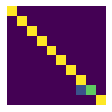

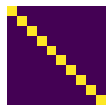

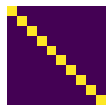


accuracy = 0.992

accuracy = 0.950


In [26]:
K = 3 # number of fold

for i,gamma in enumerate([0.5,1.5,2.5]):
    accuracy = []
    for k in range(K):        
        # train/test split
        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 1/3, shuffle = True, stratify = y)
        # call function
        confusion, accuracy_k = signal_predict(X_train, Y_train, X_test, Y_test, gamma)
        accuracy.append(accuracy_k)
        if i == 1:
            plt.subplot(1,K,k+1)
            plt.imshow(confusion)
            plt.axis('off')

    print('\naccuracy = {:.3f}'.format(np.mean(accuracy)))

## protocol 2
A database containing only one pronunciation of each number is used as a training database. The remaining repetitions are used for the test set. This procedure aims at evaluating the generalization capabilities of the recognition system.

In [17]:
# train/test split
X_train, Y_train = [], []
X_test, Y_test = [], []
for number in np.arange(0,n):
    R_train = randint(0,12)
    for R in np.arange(1,r):
        # train
        key = 'R_' + str(R) + '_N_' + str(number)
        if key == 'R_' + str(R_train) + '_N_' + str(number):
            X_train.append(signals[key])
            Y_train.append(int(key[-1]))
        else:
            X_test.append(signals[key]) 
            Y_test.append(int(key[-1]))
                    
# call function
confusion, accuracy = signal_predict(X_train, Y_train, X_test, Y_test)
    
print('confusion =')
print(confusion)
print('\naccuracy = {:.3f}'.format(accuracy))

confusion =
[[11  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  1  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0]
 [ 0  0  2  0  9  0  0  0  0  0]
 [ 0  1  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  8  3  0  1  0  0]
 [ 1  0  0  0  1  0  0  8  0  1]
 [ 1  0  0  0  0  0  0  0  9  1]
 [ 0  0  4  0  0  0  0  0  0  7]]

accuracy = 0.775


## protocol 3
The first half of the database of SIG_MIXED is used as a training database and the second half as the test database. The procedure is repeated by inversing the role of the two sets. This procedure aims at evaluating the generalization capabilities on a database containing data from the two speakers.

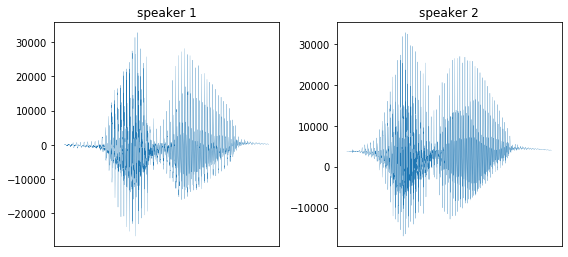

In [18]:
# Load data and plot some of them
plt.figure(figsize=(8,4))

sample_rate, signals = wavfile.read('Data/SIG/SIG_Rep_1_Number_0.wav')
plt.subplot(1,2,1)
plt.plot(signals,linewidth=0.2)
plt.xticks(())
plt.title('speaker 1')
        
sample_rate, signals = wavfile.read('Data/SIG/SIG_Rep_7_Number_0.wav')  
plt.subplot(1,2,2)
plt.plot(signals,linewidth=0.2)
plt.xticks(())          
plt.title('speaker 2')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [19]:
X1, Y1 = [], []
X2, Y2 = [], []
for number in np.arange(0,10):
    for R in np.arange(1,13):
        key = 'R_'+str(R)+'_N_'+str(number)
        sample_rate, signals = wavfile.read('Data/SIGMIX/SIGMIX_Rep_'+str(R)+'_Number_'+str(number)+'.wav')
        if R <= 6:
            X1.append(signals)
            Y1.append(number)
        else:
            X2.append(signals)
            Y2.append(number)  

# call function
confusion, accuracy_k = signal_predict(X1, Y1, X2, Y2)
print("1st case :\n")  
print('confusion =')
print(confusion)
print('\naccuracy = {:.3f}\n'.format(accuracy_k))

# call function
confusion, accuracy_k = signal_predict(X2, Y2, X1, Y1)
print("2nd case :\n")  
print('confusion =')
print(confusion)
print('\naccuracy = {:.3f}'.format(accuracy_k))

1st case :

confusion =
[[2 0 1 3 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 3 0]
 [2 1 1 0 0 1 0 0 1 0]
 [0 0 4 0 0 0 1 0 1 0]
 [0 0 1 0 0 1 0 1 3 0]
 [0 0 0 0 0 0 0 0 6 0]
 [1 5 0 0 0 0 0 0 0 0]]

accuracy = 0.350

2nd case :

confusion =
[[1 0 3 0 0 0 0 0 0 2]
 [0 5 1 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 4]
 [0 0 2 0 0 0 0 0 0 4]
 [0 1 0 0 0 0 1 1 0 3]
 [0 0 0 0 0 0 4 0 0 2]
 [0 0 1 0 0 0 0 4 0 1]
 [0 0 0 0 0 0 3 2 1 0]
 [0 0 2 0 0 0 0 0 0 4]]

accuracy = 0.417


**1. Evaluate the recognition with protocol 1 on the data SIG, and then on the data SIG2. What are the confusions? What value of parameter offers the best results ?**

<font color="blue">
In protocol 1, we have that digit 8 and 7 are mistaken one time. And $\gamma = 1.5$ give a better generalize performance that $0.5$ and $2.5$.
</font>

**2. Evaluate the generalization capabilities using protocol 2 on the data SIG, and then on the data SIG2. What do you notice?**       

<font color="blue">
We notice that performance has decreased by using only one reference for each classes, certainly due to the fact it is easier to mistaken a digit for another if there are both far from the only one reference pronunciation.
</font>

**3. Evaluate the generalization capabilities to other speakers using protocol 3 on SIG_MIXED. Explain the results.**        

<font color="blue">
The algorithm generalize very badly to other speaker, we obtain a very poor accuracy because a speaker has his own pitch and intonation of voice, the signal features varies from one interlocutor to another and the dynamic time warping is adapted to this case as it make the assumption that the signal is the same and only the time is warped.
</font>

**4. What are the limitations of dynamic time warping approaches for speech recognition that you have identified during this lab? Propose possible solutions to these problems.**

<font color="blue">
    
- It is a method to align sequences that are time warped versions of each other. That means that the sequences represent the same order of events but with differents durations. This assumption means that each element of one sequence must be matched to an element of the other sequence. So, if one sequence is a bit higher/lower to the other sequence or if the overall structure of the two sequences are different, the algorithm might fail and produces undesired alignments. A solution to this problem is to be able to skip unmatchable parts of either sequence (with an adapted cost).       
   
   
- The computation time can be quite high because we compute the distance for all pair of cepstral vectors and for all reference sequence (train data), so we can imagine that if we try it with larger sequence (not number but whole sentence, for instance), the computation time would be too long. A solution will be to compute only values around the diagonal in the similarity and cumulative distance matrix because the further we are from the diagonal, the greater the distances computed must be and then there is very little chance that the optimal path goes through these places.         
     
     
- As shown, it is only specific to a particular speaker as pitch and intonation of the voice varies from one interlocutor to another. It may be possible to put on the same scale the signal or the cepstral vectors to ensure that there is the least variation due to the changement of speaker.          
      
      
- Another limitations, is that this method need actual training examples, a preparation of reliable reference templates is mandatory to have for the set of words to be recognized and it is better to have multiple examples for each word. 

</font>

# Test Google API

https://realpython.com/python-speech-recognition/

In [20]:
!pip install googledrivedownloader

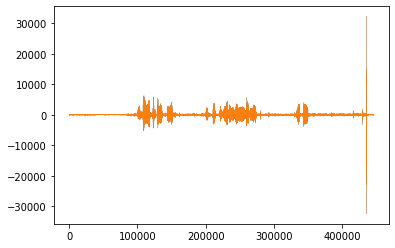

In [21]:
import IPython.display as ipd
from google_drive_downloader import GoogleDriveDownloader as gdd


file      = 'Enregistrement.wav'
path_user = 'C:\\Users\\julien.LAPTOP-V4T667QN\\Documents\\Master_IA\\Multimodal_Systems\\Data\\'
gdd.download_file_from_google_drive(file_id='https://drive.google.com/open?id=11Zkaw_F3ka726yTsQyVWW9w8230TGJMf', dest_path=path_user + file)


sample_rate, signals = wavfile.read(path_user + file)
plt.plot(signals,linewidth=0.2)
plt.show()

ipd.Audio(path_user + file)

In [22]:
import speech_recognition as sr

rgn = sr.Recognizer()
with sr.AudioFile('Data/enregistrement.wav') as source:
    audio = rgn.record(source)

rgn.recognize_google(audio, language='fr-FR')

"Bonjour Monsieur correcteur j'espère que vous allez me donner une bonne note merci"